In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
print("Pandas version used: " + pd.__version__)
print("Matplotlib version used: " + plt.matplotlib.__version__)
print("Numpy version used: " + np.__version__)
print("Seaborn version used: " + sns.__version__)
print("Statsmodels version used: " + sm.__version__)
print("Scikit-learn version used: " + sklearn.__version__)

Pandas version used: 1.0.5
Matplotlib version used: 3.2.2
Numpy version used: 1.18.5
Seaborn version used: 0.10.1
Statsmodels version used: 0.11.1
Scikit-learn version used: 0.23.1


<h3>In this notebook I will begin using a few models to see if the scores for the various tests and the average score for all tests can be predicted by the various features given concerning each student.

In [2]:
# Read in the dataset:
stu_perf_df = pd.read_csv("Datasets/stu_perf_clean.csv",index_col='stu_id')

In [3]:
# Make sure the dataset looks good still:
stu_perf_df.head()

,female,eth_A,eth_B,eth_C,eth_D,p_ed_hs,p_ed_som_col,p_ed_assc,p_ed_bach,p_ed_mast,std_lunch,test_prep,math_score,reading_score,writing_score,avg_score
stu_id,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,1,0,71,59,54,61.33
1,1,0,1,0,0,0,0,0,0,0,0,0,40,51,49,46.67
2,0,0,1,0,0,0,0,1,0,0,1,0,87,73,75,78.33
3,0,0,0,1,0,0,0,0,0,0,1,0,69,53,55,59.00
4,1,0,0,1,0,1,0,0,0,0,1,0,74,79,72,75.00


<h3>Next I will set all of the training/testing variables for the average_score predicting models:
<br><br>
I will use the holdout method for validation, since this is a regression problem and our sample size is a decent size:

In [4]:
# Define the feature columns:
train_cols = stu_perf_df.columns[:-4]

# Perform train_test_split, reservig 30% for testing:
X_train, X_test, y_train, y_test = train_test_split(stu_perf_df[train_cols],
                                                    stu_perf_df.avg_score,
                                                    test_size=0.3,
                                                    random_state=2020)

<h3>First, I want to try to apply a least squares approach to predicting the average score:

In [5]:
# Add a constant to the training set for linear regression:
X_lin_train = sm.add_constant(X_train)

# Create the model:
lin_avg_mod = sm.OLS(y_train, X_lin_train, hasconst=True)

# Fit the model:
lin_avg_res = lin_avg_mod.fit()

# Get a summary of all of the critical details about the model:
print(lin_avg_res.summary())

# Including the total MSE and RMSE so we can compare it to the classification trees later:
mse = lin_avg_res.mse_total
rmse = np.sqrt(lin_avg_res.mse_total)
print('\nMSE: ' + str(mse))
print('\nRMSE: ' + str(rmse))

                            OLS Regression Results                            
Dep. Variable:              avg_score   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     119.3
Date:                Tue, 13 Oct 2020   Prob (F-statistic):          9.58e-250
Time:                        14:32:33   Log-Likelihood:                -13719.
No. Observations:                3500   AIC:                         2.746e+04
Df Residuals:                    3487   BIC:                         2.754e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           59.5656      0.802     74.276   

<h3>According to the summary, this model is not great for predicting the average test scores for the students. The R-squared, at 0.291, means the average score is not explained well by the independent variables. While all of the variables are important (indicated by their low p-values), they do not seem to be major predictors of the test results.

<h3>Though not a great model, we can see that the student's parents having a bachelor or master degree has greater weight than some of the other options. So is having the standard lunch, which again suggests some sort of socioeconomic element to improved test performance. Obviously, completing the test prep course is also a stronger predictor than the others.

<h3>The RMSE, at around 14.48, is not great either, but we've already established that this is not an ideal model for this type of data or that these features are not very good predictors in general.

<h3>Finally we could plot the residuals vs. the predicted values and the actual values vs. the predicted values to demonstrate the variance present in the model:

Text(0.5, 1.0, 'OLS Residuals vs. Predicted Test Scores')

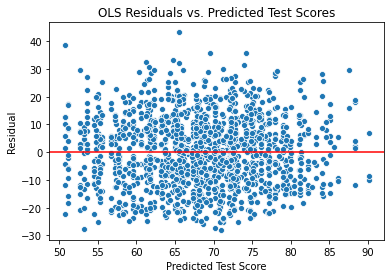

In [6]:
# Prep the test variable for lin_reg:
X_lin_test = sm.add_constant(X_test)

# Use the model to predict the avg_score for the test set features:
test_pred = lin_avg_res.predict(X_lin_test)

# Subtract the actual results from the predicted results to get residual:
test_resid = test_pred - y_test

# Create a scatter plot of the residuals vs. the test predictions:
sns.scatterplot(test_pred, test_resid)
plt.xlabel('Predicted Test Score')
plt.ylabel('Residual')
plt.axhline(y=0, c='r')
plt.title("OLS Residuals vs. Predicted Test Scores")

<h3>There is no unusual pattern to the residual plot, but there is still a lot of variance that suggests the model is not going to produce very accurate predictions.

Text(0, 0.5, 'Actual Test Score')

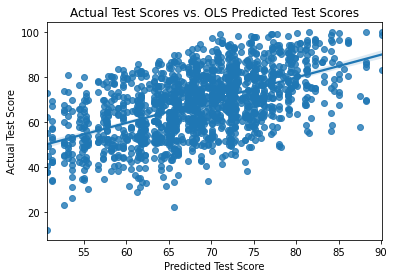

In [7]:
# Create a regression plot of the actual test scores vs. the ones predicted by the OLS model:
plt.title("Actual Test Scores vs. OLS Predicted Test Scores")
sns.regplot(test_pred, y_test)
plt.xlabel('Predicted Test Score')
plt.ylabel('Actual Test Score')

<h3>Next, I will look at how well a decision tree can predict the average score based off of the categorical features for each student:

In [8]:
# Prepare the model. After several iterations, 100 seems to be a good min_samples_split and seems to produce
# the best results (hopefully without overfitting):
estimator = tree.DecisionTreeRegressor(min_samples_split=100)
# Fit the model:
estimator.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_split=100)

In [9]:
# Print out the R^2 for the decision tree:
est_r_sq = estimator.score(X_test, y_test)
print('R^2: ' + str(est_r_sq))

R^2: 0.24515548310674407


<h3>The R^2 for the decision tree seems to be slightly worse than the linear model. 0.24 vs. 0.29. This reinforces the idea that these features are not good explanatory variables for the data.

In [10]:
# Display the total MSE and RMSE for the test data so we can compare it to the linear model:
tree_avg_pred = estimator.predict(X_test)

tree_mse = mean_squared_error(y_test, tree_avg_pred)
tree_rmse = np.sqrt(tree_mse)

print('MSE: ' + str(tree_mse))
print('\nRMSE: ' + str(tree_rmse))

MSE: 159.8348004746413

RMSE: 12.642578869623131


<h3>The RMSE seems to show a slight improvement over the linear model (12.64 vs. 14.48), however.

Text(0.5, 1.0, 'D. Tree Residuals vs. Predicted Test Scores')

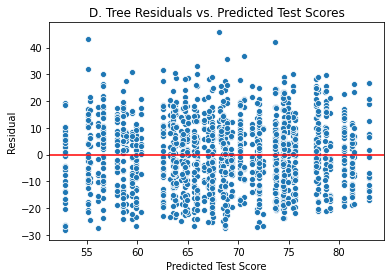

In [11]:
# Subtract the actual results from the predicted results to get residual:
tree_resid = tree_avg_pred - y_test

# Create a scatter plot of the residuals vs. the test predictions:
sns.scatterplot(tree_avg_pred, tree_resid)
plt.xlabel('Predicted Test Score')
plt.ylabel('Residual')
plt.axhline(y=0, c='r')
plt.title("D. Tree Residuals vs. Predicted Test Scores")

Text(0, 0.5, 'Actual Test Score')

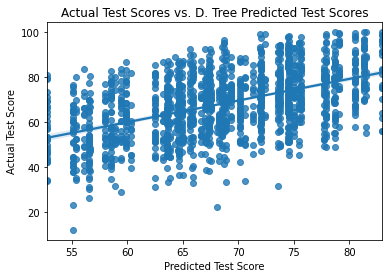

In [12]:
# Create a regression plot of the actual test scores vs. the d. tree predicted ones:
plt.title("Actual Test Scores vs. D. Tree Predicted Test Scores")
sns.regplot(tree_avg_pred, y_test)
plt.xlabel('Predicted Test Score')
plt.ylabel('Actual Test Score')

<h3>While the model seems to get some of the results right, the model is unable to predict any of the values lower than 50 and otherwise displays a wide array of variance.

<h3>In conclusion, while these features bear some impact on the average score that students achieve, they are definitely not the most important features or these are not good models to use with this data. In order to produce a better predictor, additional features should be collected such as previous grades, highest math completed, time spent studying, etc. Additional types of models should also be utilized to see if they can perform better.